# The Devil lives in the details
> Resizing method matters...

- toc: true 
- badges: true
- comments: true
- categories: [Pytorch, fastai]
- author: Thomas Capelle

Yesterday I was refactoring some code to put on our production code base. It is a simple image classifier trained with fastai. In our deployement env we are not including fastai as requirements and rely only on pure pytorch to process the data and make the inferece. (I am waiting to finally be able to install only the fastai vision part, without the NLP dependencies, this is coming soon, probably in fastai 2.3, at least it is in [Jeremy's roadmap](https://github.com/fastai/fastai/projects/1#card-52606857)). So, I have to make the reading and preprocessing of images as close as possible as fastai `Transform` pipeline, to get accurate model outputs. 

Let's take a quick look on the preprocessing used for training and there corresponding torch version with the new tensor API as shown [here](https://github.com/pytorch/vision/blob/master/examples/python/tensor_transforms.ipynb)

## A simple example
> Let's make a simple classifier on the PETS dataset, for more details this comes from the [fastai tutorial](https://docs.fast.ai/tutorial.vision.html)

In [376]:
#collapse-hide
from fastai.vision.all import *
set_seed(2021)

let's grab the data

In [216]:
path = untar_data(URLs.PETS)
files = get_image_files(path/"images")

def label_func(f): 
    return f[0].isupper()

dls = ImageDataLoaders.from_name_func(path, files, label_func, item_tfms=Resize((256, 192)))

A learner it is just a wrapper of Dataloaders and the model. We will grab an imagene pretrained `resnet18`, we don't really need to train it to illustrate the problem.

In [374]:
learn = cnn_learner(dls, resnet18)

and grab one image (`load_image` comes from fastai and returns a memory loaded `PIL.Image.Image`)

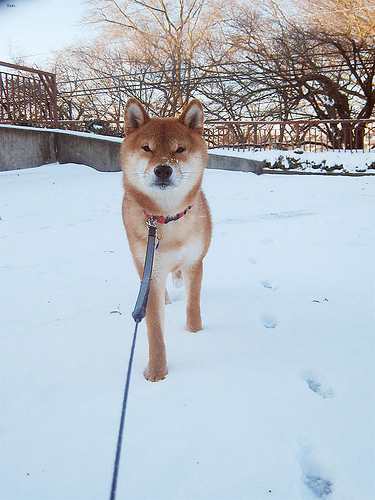

In [218]:
fname = files[1]
img = load_image(fname)
img

In [219]:
learn.predict(fname)

('False', tensor(0), tensor([0.9191, 0.0809]))

### Let's understand what is happening under the hood:

and we can call the prediction using fastai `predict` method, this will apply the same transforms as to the validation set.
- create PIL image
- Transform the image to pytorch Tensor
- Scale values by 255
- Normalize with imagenet stats

doing this by hand is extracting the preprocessing transforms:

In [229]:
dls.valid.tfms

(#2) [Pipeline: PILBase.create,Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}]

In [230]:
dls.valid.after_item

Pipeline: Resize -- {'size': (192, 256), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0} -> ToTensor

In [231]:
dls.valid.after_batch

Pipeline: IntToFloatTensor -- {'div': 255.0, 'div_mask': 1} -> Normalize -- {'mean': tensor([[[[0.4850]],

         [[0.4560]],

         [[0.4060]]]]), 'std': tensor([[[[0.2290]],

         [[0.2240]],

         [[0.2250]]]]), 'axes': (0, 2, 3)}

Let's put all transforms together on a fastcore `Pipeline`

In [236]:
preprocess = Pipeline([Transform(PILImage.create), 
                       Resize((256,192)), 
                       ToTensor, 
                       IntToFloatTensor, 
                       Normalize.from_stats(*imagenet_stats)])

we can then preprocess the image:

In [238]:
tfm_img = preprocess(fname)
tfm_img.shape

torch.Size([1, 3, 256, 192])

and we get the exact same predictions as before

In [239]:
with torch.no_grad():
    preds = model(tfm_img).softmax(1)
preds

tensor([[0.9191, 0.0809]])

## Using torchvision preprocessing
> Now let's try to replace fastai transforms with torchvision

In [378]:
import PIL
import torchvision.transforms as T

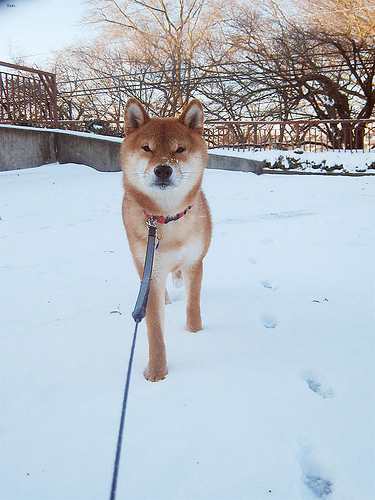

In [379]:
pil_image = load_image(fname)
pil_image

In [380]:
type(pil_image)

PIL.Image.Image

let's first resize the image, we can do this directly over the `PIL.Image.Image` or using `T.Resize` that works both on `IPIL` images or `Tensor`s

In [381]:
resize = T.Resize([256, 192])
res_pil_image = res(pil_image)

we can then use `T.ToTensor` this will actually scale by 255 and transform to tensor, it is equivalent to both `ToTensor` + `IntToFloatTensor` from fastai.

In [382]:
timg = T.ToTensor()(res_pil_image)

then we have to normalize it:

In [383]:
norm = T.Normalize(*imagenet_stats)
nimg = norm(timg).unsqueeze(0)

and we get almost and identical results! ouff.....

In [384]:
with torch.no_grad():
    preds = model(nimg).softmax(1)
preds

tensor([[0.9109, 0.0891]])

## Torchvision new Tensor API
> Let's try this new Tensor based API that torchvision introduced on `v0.8` then!

In [385]:
import torchvision.transforms as T
from torchvision.io.image import read_image

`read_image` is pretty neat, it actually read directly the image to a pytorch tensor, so no need for external image libraries. Using this API has many advantages, as one can group the model and part of the preprocessing as whole, and then export to torchscript all togeter: model + preprocessing, as shown in the example [here](https://github.com/pytorch/vision/blob/master/examples/python/tensor_transforms.ipynb)

In [386]:
timg = read_image(str(fname)) # it is sad that it does not support pathlib objects in 2021...

In [394]:
resize = T.Resize([256, 192])
res_timg = res(timg)

we have to scale it, we have a new transform to do this:

In [395]:
scale = T.ConvertImageDtype(torch.float)
scaled_timg = scale(res_timg)

In [396]:
norm = T.Normalize(*imagenet_stats)
nimg = norm(scaled_timg).unsqueeze(0)

Ok, the results is pretty different...

In [397]:
with torch.no_grad():
    preds = model(nimg).softmax(1)
preds

tensor([[0.9844, 0.0156]])

if you trained your model with the old API, reading images using PIL you may find yourself lost as why the models is performing poorly. My classifier was predicting completely the opossite for some images, and that's why I realized that something was wrong! 

Let's dive what is happening...

## Comparing Resizing methods
> T.Resize on PIL image vs Tensor Image

We will use fastai's `show_images` to make the loading and showing of tensor images easy

In [405]:
resize = T.Resize([256, 192], interpolation=PIL.Image.BILINEAR)

In [406]:
pil_img = load_image(fname)
res_pil_img = image2tensor(resize(pil_img))

tensor_img = read_image(str(fname))
res_tensor_img = resize(tensor_img)

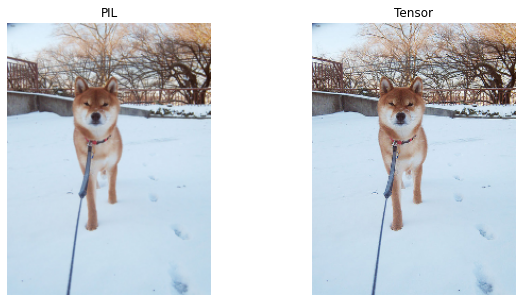

In [407]:
show_images([res_pil_img, res_tensor_img], figsize=(10,5), titles=['PIL', 'Tensor'])

Let's zoome and plot

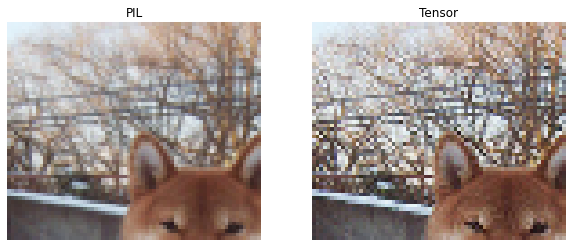

In [408]:
show_images([res_pil_img[:,20:80, 30:100], res_tensor_img[:,20:80, 30:100]], figsize=(10,5), titles=['PIL', 'Tensor'])

The `PIL` image is smoother, it is not necesarily better, but it is different. From my testing, for darker images the `PIL` reisze has less moire effect (less noise)

## Extra: What if I want to use OpenCV?
> A popular choice for pilepines that rely on numpy array transforms, as [Albumnetation](https://github.com/albumentations-team/albumentations/blob/master/docs/index.rst)

In [420]:
import cv2

opencv opens directly an array

In [410]:
img_cv = cv2.imread(str(fname))
res_img_cv = cv2.resize(img_cv, 
                         (256,192), 
                         interpolation=cv2.INTER_LINEAR)

BGR to RGB, and channel first.

In [411]:
res_img_cv = res_img_cv.transpose((2,0,1))[::-1,:,:].copy()

In [412]:
timg_cv  = cast(res_img_cv, TensorImage)
timg_cv.shape

torch.Size([3, 192, 256])

<AxesSubplot:>

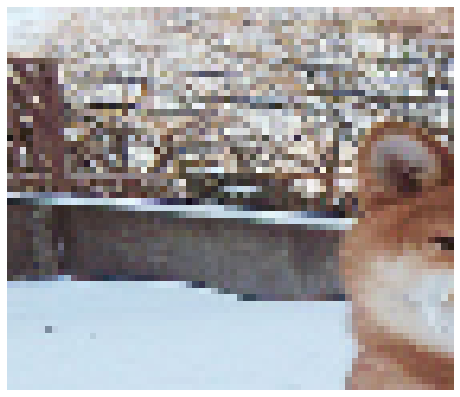

In [413]:
timg_cv[:,20:80, 30:100].show(figsize=(8,8))

pretty bad also...

In [414]:
learn.predict(timg_cv)

('True', tensor(1), tensor([0.4923, 0.5077]))

### with `INTER_AREA` flag
> This method is closer to PIL image resize, as it has a kernel that smooths the image.

In [415]:
img_cv_area = cv2.imread(str(fname))
img_cv_area = cv2.resize(img_cv_area, 
                         (256,192), 
                         interpolation=cv2.INTER_AREA)

In [416]:
img_cv_area = img_cv_area.transpose((2,0,1))[::-1,:,:].copy()

In [417]:
timg_cv_area  = cast(img_cv_area, TensorImage)

<AxesSubplot:>

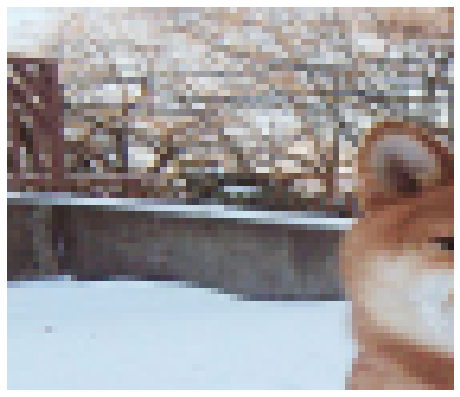

In [418]:
timg_cv_area[:,20:80, 30:100].show(figsize=(8,8))

kinda of better...

In [419]:
learn.predict(timg_cv_area)

('False', tensor(0), tensor([0.9602, 0.0398]))

## Conclusions

Ideally, deploy the model with the exact same transforms as it was validated. Or at least, check that the preformance does not degrade.
I would like to see more consistency between both API in pure pytorch, as the user is pushed to use the new `pillow-free` pipeline, but results are not consistent. Resize is a fundamental part of the image preprocessing in most user cases.

- There is an issue [open](https://github.com/pytorch/vision/issues/2950) on the torchvision github about this.
- Also one about the difference between PIL and openCV [here](https://github.com/python-pillow/Pillow/issues/2718)

This was pretty frustrating, as it was not obviuos where the model was failing.